In [13]:
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
from file import save_file
from statistics import mean
from datetime import date
import file

In [14]:
# Define the ticker symbol
tickerSymbol = 'TQQQ'

# Get data on this ticker
tickerData = yf.Ticker(tickerSymbol)

# Get the historical prices for this ticker
history = tickerData.history(interval='1wk', start='2021-1-1', end=date.today())
# display(history)

In [15]:
CL = history['Low'].shift(-1) / history['Close'] - 1
print(f'{tickerSymbol} Close to next Low')
print(f'  20%: {CL.quantile(0.2):.2%}')
print(f'  50%: {CL.quantile(0.5):.2%}')
print(f'  80%: {CL.quantile(0.8):.2%}')

TQQQ Close to next Low
  20%: -10.40%
  50%: -4.43%
  80%: -1.53%


In [16]:
max_weeks = 50
gap = (1/52)*100
# option_prices = {
#     1: [56/1.42, 57/1.23, 59/1.54],
#     2: [56/2, 57/2.03, 59/2.34],
#     3: [56/2.53, 57/2.68, 59/2.71],
#     4: [52/3.22, 56/3.1, 57/2.98, 59/3.15],
#     5: [56/3.42, 57/3.08, 59/3.31],
#     6: [56/3.47, 57/3.7, 59/3.9],
#     7: [57/4.15, 59/3.43],
#     8: [56/4.4],
#     9: [52/4.87],
#     19: [59/7.37],
#     20: [57/7.37],
#     21: [56/7.3],
#     22: [52/7.65],
#     32: [59/10.23],
#     33: [57/10.02],
#     34: [56/9.95],
#     35: [52/9.98],
#     36: [59/10.8],
#     37: [57/10.57],
#     38: [56/10.75],
#     39: [52/10.42]
# }
# print('option leverages:')
# for w in option_prices:
#     print(f'\t{w:2}w', *[f'{x:4.1f}' for x in option_prices[w]])

# option_leverage = {w:mean(option_prices[w]) for w in option_prices}
option_leverage = {
    1: 34.75609756097561,
    2: 22.673160173160174,
    3: 17.605633802816904,
    4: 15.73214901690238,
    5: 14.029649595687331,
    6: 12.614678899082568,
    7: 11.707317073170733,
    8: 10.9375,
    9: 10.825791855203619,
    10: 8.482142857142858,
    11: 8.16326530612245,
    12: 7.317826265953068,
    13: 7.170761797059731,
    14: 6.511875033207588,
    15: 7.40952380952381,
    16: 6.41399416909621,
    17: 7.204610951008645,
    18: 6.633849038912331,
    19: 6.763191763191763,
    20: 6.961191961191961,
    21: 6.411483253588518,
    22: 6.459131545338442,
    23: 5.658529766634295,
    24: 5.612134344528711,
    25: 4.963924963924963,
    26: 4.906204906204906}
print('mean option leverage, break even:')
for w in option_leverage:
    print(
        f'\t{w:2}w {option_leverage[w]:4.1f} {gap + 100/option_leverage[w]:4.1f}%')
print(f'option gap: {gap:.2f}%')

file.save_option_leverage(tickerSymbol, option_leverage)

mean option leverage, break even:
	 1w 34.8  4.8%
	 2w 22.7  6.3%
	 3w 17.6  7.6%
	 4w 15.7  8.3%
	 5w 14.0  9.1%
	 6w 12.6  9.9%
	 7w 11.7 10.5%
	 8w 10.9 11.1%
	 9w 10.8 11.2%
	10w  8.5 13.7%
	11w  8.2 14.2%
	12w  7.3 15.6%
	13w  7.2 15.9%
	14w  6.5 17.3%
	15w  7.4 15.4%
	16w  6.4 17.5%
	17w  7.2 15.8%
	18w  6.6 17.0%
	19w  6.8 16.7%
	20w  7.0 16.3%
	21w  6.4 17.5%
	22w  6.5 17.4%
	23w  5.7 19.6%
	24w  5.6 19.7%
	25w  5.0 22.1%
	26w  4.9 22.3%
option gap: 1.92%


In [17]:
stock_change = [None] # no change for 0 weeks
option_performance = []
history['Change'] = history['Close'].pct_change(periods=1) * 100
for weeks in range(1, max_weeks):
    stock_changes = history['Close'].pct_change(periods=weeks) * 100
    stock_change.append(stock_changes.median() * 52 / weeks) # annualized

    if weeks in option_leverage:
        lvr = option_leverage[weeks]
        option_profits = ((stock_changes[weeks:] - gap) * lvr - 100).clip(lower=-100)
        mean_profit = option_profits.mean() #* 52 / weeks # annualized
        positive_percent = (option_profits > 0).mean() * 100
        option_performance.append([weeks, mean_profit, positive_percent])
        history[f'Option {weeks}w'] = option_profits # ? * 52 / weeks # annualized

In [18]:
print('Option performance (weeks, profit, positive):')
for p in option_performance:
    print(f'\t{p[0]:2}w {p[1]:4.0f}% {p[2]:3.0f}%')

Option performance (weeks, profit, positive):
	 1w   -3%  28%
	 2w    2%  35%
	 3w    9%  41%
	 4w   16%  41%
	 5w   20%  37%
	 6w   20%  41%
	 7w   19%  41%
	 8w   21%  43%
	 9w   27%  44%
	10w    7%  42%
	11w    9%  42%
	12w    7%  42%
	13w   13%  42%
	14w    8%  42%
	15w   28%  47%
	16w   16%  45%
	17w   37%  48%
	18w   32%  48%
	19w   43%  50%
	20w   54%  52%
	21w   49%  52%
	22w   56%  50%
	23w   43%  52%
	24w   49%  52%
	25w   37%  51%
	26w   42%  53%


In [19]:

save_file(tickerSymbol, option_performance)


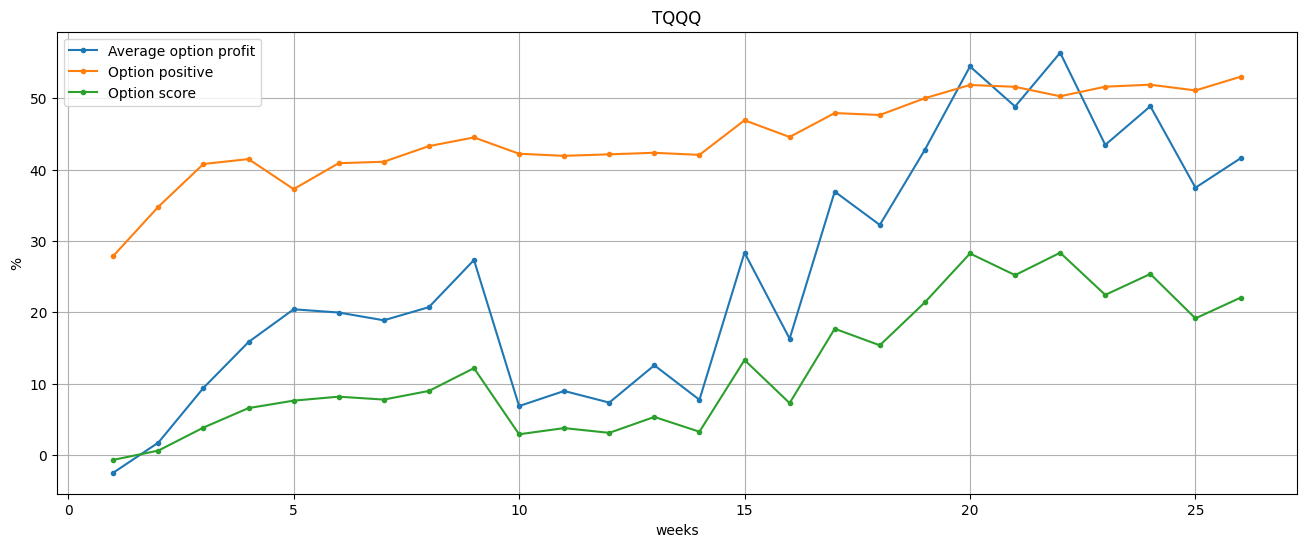

In [20]:
plt.figure(figsize=(16,6))
option_weeks = [p[0] for p in option_performance]
option_profit = [p[1] for p in option_performance]
option_positive = [p[2] for p in option_performance]
option_score = [x * y / 100 for x, y in zip(option_profit, option_positive)]
plt.plot(option_weeks, option_profit, label='Average option profit', marker='.')
plt.plot(option_weeks, option_positive, label='Option positive', marker='.')
plt.plot(option_weeks, option_score, label='Option score', marker='.')
plt.legend(loc='upper left')
plt.title(tickerSymbol)
plt.xlabel('weeks')
plt.ylabel('%')
plt.grid()
plt.show()

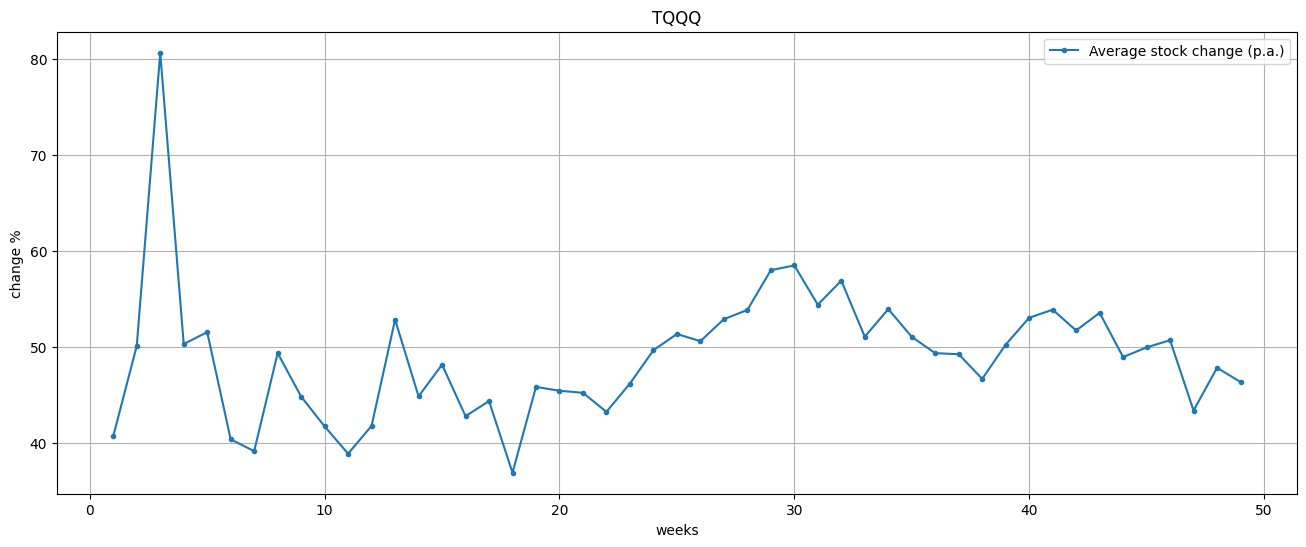

In [21]:
plt.figure(figsize=(16,6))
plt.plot(stock_change, label='Average stock change (p.a.)', marker='.')
plt.legend(loc='upper right')
plt.title(tickerSymbol)
plt.xlabel('weeks')
plt.ylabel('change %')
plt.grid()
plt.show()


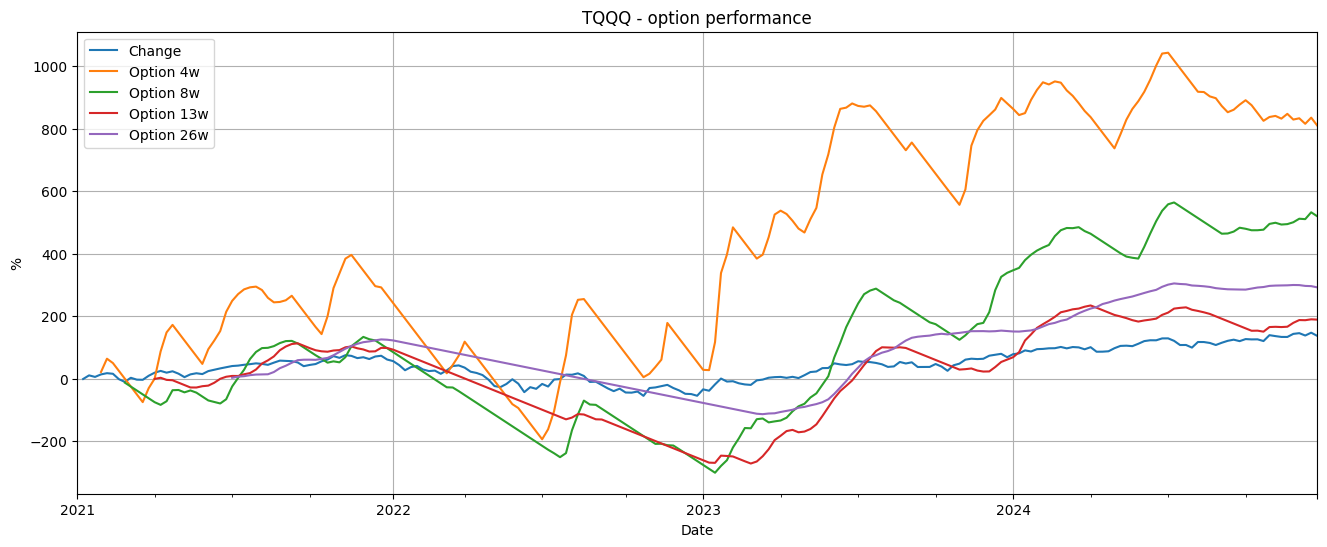

In [29]:
plt.figure(figsize=(16,6))
history['Change'].cumsum().plot()

for w in [4,8,13,26]:
    (history[f'Option {w}w'].cumsum()/w).plot()

plt.legend(loc='upper left')
plt.title(f'{tickerSymbol} - option performance')
plt.ylabel('%')
# plt.yscale('log')
plt.grid()
plt.show()


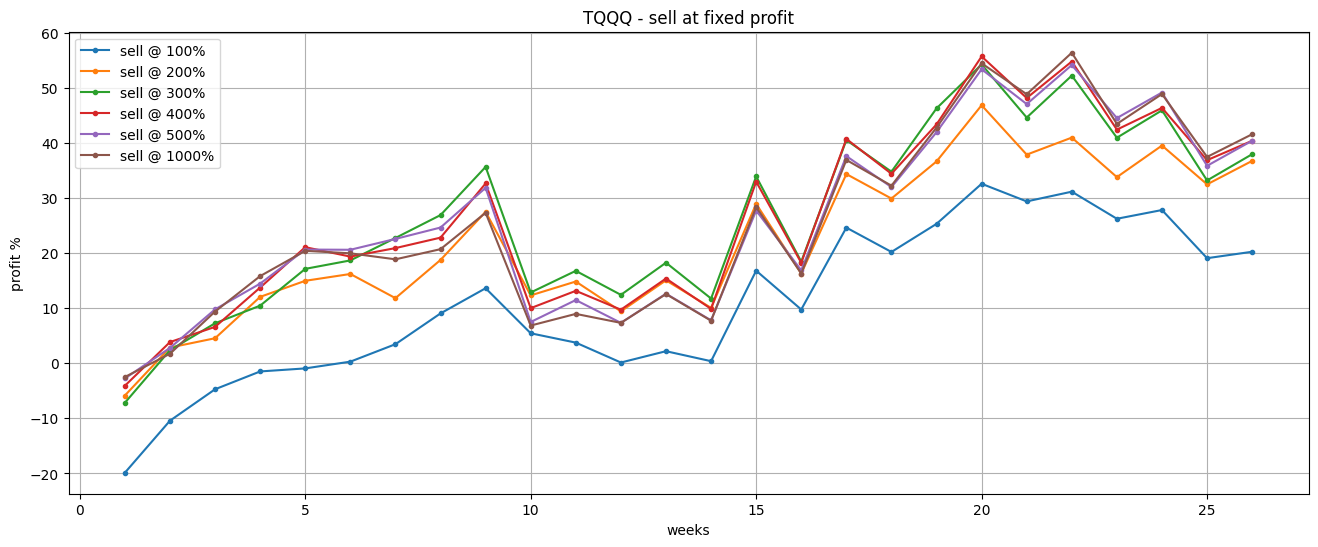

In [25]:
plt.figure(figsize=(16,6))

for maxprofit in [100,200,300,400,500,1000]:
    data = {}
    for weeks in option_leverage:
        lvr = option_leverage[weeks]
        WStart = history.Close.shift(weeks)
        WHigh = history.High.rolling(window=weeks).max()
        eow_profit = (((history.Close / WStart - 1) * 100 - gap) * lvr - 100).clip(lower=-100)
        wmax_profit = (((WHigh / WStart - 1) * 100 - gap) * lvr - 100).clip(upper=maxprofit)
        profit = wmax_profit.where(wmax_profit >= maxprofit, eow_profit)
        data[weeks] = profit[weeks:].mean()

    plt.plot(*zip(*sorted(data.items())), label=f'sell @ {maxprofit}%', marker='.')

plt.legend()
plt.title(f'{tickerSymbol} - sell at fixed profit')
plt.xlabel('weeks')
plt.ylabel('profit %')
plt.grid()
plt.show()